# 注意！ CPUじゃマジで無理だから

# データセットの準備

In [70]:
from keras.datasets import cifar10

(X_trainval, y_trainval), (X_test, y_test) = cifar10.load_data()

In [71]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_trainval,
                                                  y_trainval,
                                                  random_state=0)

In [72]:
from keras.utils import to_categorical

y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

In [73]:
# 勉強のためにデータセットをへらす
X_train = X_train[:1500]
y_train = y_train[:1500]

X_val = X_val[:1500]
y_val = y_val[:1500]

# ネットワークの準備


In [75]:
from keras.applications  import VGG16

conv_base = VGG16(weights="imagenet",
              include_top=False,
              input_shape=(32, 32, 3))

conv_base.trainable = False

conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0         
__________

# カスタムネットワーク

In [90]:
from keras import layers, models

model = models.Sequential()

model.add(conv_base)

model.add(layers.Flatten())
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(10, activation="softmax"))

In [91]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_12 (Flatten)         (None, 512)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 10)                2570      
Total params: 14,848,586
Trainable params: 7,213,322
Non-trainable params: 7,635,264
_________________________________________________________________


# 追加した部分の訓練を行なう

In [81]:
from keras import optimizers

model.compile(optimizer=optimizers.RMSprop(lr=1e-4),
              loss="categorical_crossentropy",
              metrics=["acc"])

history = model.fit(X_train,
                    y_train,
                    validation_data=(X_val, y_val),
                    batch_size=32,
                    epochs=2)

Train on 1500 samples, validate on 1500 samples
Epoch 1/2
1500/1500 [==============================] - 14s 9ms/step - loss: 8.7429 - acc: 0.2513 - val_loss: 9.1028 - val_acc: 0.2293
Epoch 2/2
1500/1500 [==============================] - 14s 9ms/step - loss: 7.2257 - acc: 0.3440 - val_loss: 8.3703 - val_acc: 0.2540


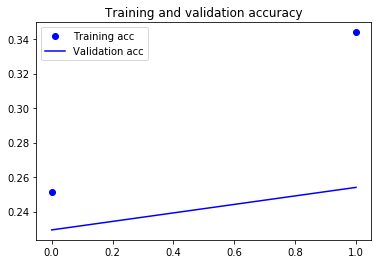

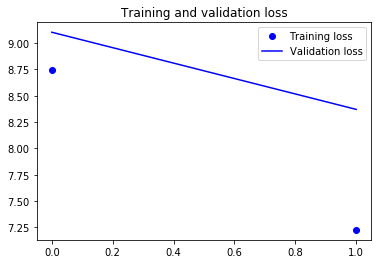

In [82]:
import matplotlib.pyplot as plt


def plot_loss_and_acc(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()
    
plot_loss_and_acc(history)   

# 一部の層を解凍する

In [85]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [86]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_11 (Flatten)         (None, 512)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_26 (Dense)             (None, 10)                2570      
Total params: 7,769,162
Trainable params: 133,898
Non-trainable params: 7,635,264
_________________________________________________________________


# 解凍した層と追加した層の訓練を同時に行う

In [88]:
model.compile(optimizer=optimizers.RMSprop(lr=1e-5), #  学習率抑えめ！
              loss="categorical_crossentropy",
              metrics=["acc"])

history_fine = model.fit(X_train,
                    y_train,
                    validation_data=(X_val, y_val),
                    batch_size=32,
                    epochs=2)

Train on 1500 samples, validate on 1500 samples
Epoch 1/2
1500/1500 [==============================] - 24s 16ms/step - loss: 6.0194 - acc: 0.4167 - val_loss: 7.1610 - val_acc: 0.3307
Epoch 2/2
1500/1500 [==============================] - 23s 15ms/step - loss: 4.2527 - acc: 0.5720 - val_loss: 6.7929 - val_acc: 0.3460


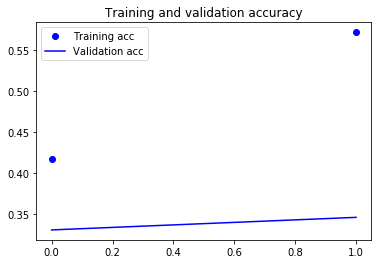

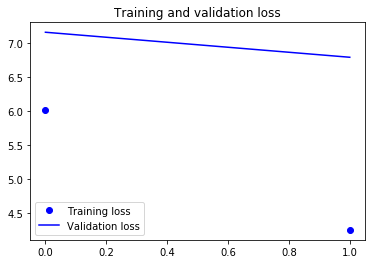

In [89]:
plot_loss_and_acc(history_fine)